# Question 3

***importing the needed libraries as below:***

In [1]:
import sys
sys.path.append('/scratch/ne2213/projects/tmp_packages')
sys.path.append('/scratch/ne2213/projects/tmp_packages/')
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import os
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from PIL import Image
from torchvision import utils 

***preparing and loading the FashionMNIST dataset***

In [2]:
# Define transformations for data augmentation
transform = transforms.Compose([
    transforms.Grayscale(),        # Convert images to grayscale
    transforms.RandomHorizontalFlip(),      # Randomly flip images horizontally
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Adjust brightness, contrast, saturation, and hue randomly
    transforms.Resize((28, 28)),   # Resize images to 28x28
    transforms.ToTensor(),         # Convert images to tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize images
])

# Load FashionMNIST dataset with transformations
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Get a sample image from the dataset
sample_image, _ = train_dataset[0]

# Check if the image is grayscale
is_grayscale = sample_image.size(0) == 1  # Grayscale images have only 1 channel

# Check the size of the image
image_height, image_width = sample_image.shape[-2:]

# Print whether the image is grayscale and its size
print("Is the image grayscale?", is_grayscale)
print("Image size:", (image_height, image_width))

Is the image grayscale? True
Image size: (28, 28)


***Define the disrcriminator architecture with the specifics below:***

***kernel size = 5 × 5, stride = 2***

***2D convolutions (1 × 28 × 28 → 64 × 14 × 14 → 128 × 7 × 7)***

***each layer equipped with a Leaky ReLU with slope 0.3, followed by Dropout with parameter 0.3***

***a dense layer that takes the flattened output of the last convolution and maps it to a scalar***

In [3]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=5, stride=2, padding=2)  # 1x28x28 -> 64x14x14
        self.conv2 = nn.Conv2d(64, 128, kernel_size=5, stride=2, padding=2)  # 64x14x14 -> 128x7x7
        self.leaky_relu = nn.LeakyReLU(0.3)
        self.dropout = nn.Dropout(0.3)
        self.flatten = nn.Flatten()
        self.dense = nn.Linear(128*7*7, 1)
        self.sigmoid = nn.Sigmoid() 

    def forward(self, x):
        x = self.conv1(x)
        x = self.leaky_relu(x)
        x = self.dropout(x)
        x = self.conv2(x)
        x = self.leaky_relu(x)
        x = self.dropout(x)
        x = self.flatten(x)
        x = self.dense(x)
        x = self.sigmoid(x)
        return x

# Instantiate the discriminator
discriminator = Discriminator()

# Generate a random input tensor
random_input = torch.randn(1, 1, 28, 28)  # Batch size 1, single channel, 28x28 image

# Forward pass and print shapes at each layer
output = discriminator(random_input)

# Print the shapes of intermediate outputs
print("Input size:", random_input.size())
print("Conv1 output shape:", discriminator.conv1(random_input).shape)
print("Conv2 output shape:", discriminator.conv2(discriminator.leaky_relu(discriminator.conv1(random_input))).shape)
print("Dense output shape:", output.shape)

Input size: torch.Size([1, 1, 28, 28])
Conv1 output shape: torch.Size([1, 64, 14, 14])
Conv2 output shape: torch.Size([1, 128, 7, 7])
Dense output shape: torch.Size([1, 1])


***Define the generator architecture with the specifics below:***

***a dense layer that takes a unit Gaussian noise vector of length 100***

***maps it to a vector of size 7 x 7 x 256, No bias terms***

***transpose 2D convolutions (256 × 7 × 7 → 128 × 7 × 7 → 64 × 14 × 14 → 1 × 28 × 28), No bias terms***

***each layer equipped with Batch Normalization followed by Leaky ReLU with slope 0.3***

***output layer equipped with tanh activation (no batch norm)***

In [4]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.dense = nn.Linear(100, 7*7*256, bias=False)  # 100 -> 7*7*256
        self.conv1 = nn.ConvTranspose2d(256, 128, kernel_size=5, stride=1, padding=2, bias=False)  # 256x7x7 -> 128x7x7
        self.conv2 = nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2, padding=2, output_padding=1, bias=False)  # 128x7x7 -> 64x14x14
        self.conv3 = nn.ConvTranspose2d(64, 1, kernel_size=5, stride=2, padding=2, output_padding=1, bias=False)  # 64x14x14 -> 1x28x28
        self.batch_norm1 = nn.BatchNorm2d(128)
        self.batch_norm2 = nn.BatchNorm2d(64)
        self.leaky_relu = nn.LeakyReLU(0.3)
        self.tanh = nn.Tanh()

    def forward(self, x):
        shapes = {}
        shapes["input"] = x.size()
        x = self.dense(x)
        x = x.view(-1, 256, 7, 7)
        shapes["dense"] = x.shape
        x = self.conv1(x)
        x = self.batch_norm1(x)
        x = self.leaky_relu(x)
        shapes["conv1"] = x.shape
        x = self.conv2(x)
        x = self.batch_norm2(x)
        x = self.leaky_relu(x)
        shapes["conv2"] = x.shape
        x = self.conv3(x)
        x = self.tanh(x)
        shapes["conv3"] = x.shape
        return x, shapes

# Instantiate the generator
generator = Generator()

# Generate a random input noise vector
random_input = torch.randn(1, 100)  # Batch size 1, noise vector of length 100

# Forward pass and print shapes at each layer
output, shapes = generator(random_input)
for layer, shape in shapes.items():
    print(f"{layer} output shape: {shape}")


input output shape: torch.Size([1, 100])
dense output shape: torch.Size([1, 256, 7, 7])
conv1 output shape: torch.Size([1, 128, 7, 7])
conv2 output shape: torch.Size([1, 64, 14, 14])
conv3 output shape: torch.Size([1, 1, 28, 28])


***Binary cross-entropy loss for training both the generator and the discriminator, Adam optimizer with learning rate 10−4, and batchsize 32***

In [5]:
lr = 1e-4
batch_size = 32
num_epochs = 50

criterion = nn.BCELoss()
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=lr)
generator_optimizer = optim.Adam(generator.parameters(), lr=lr)

# noise dimension
noise_dim = 100

# path to save generated images
output_path = "/scratch/ne2213/projects/DL/HW3-final-batch32/"
os.makedirs(output_path, exist_ok=True)

# fixed noise for visualization
fixed_noise = torch.randn(batch_size, noise_dim).to(device)

In [6]:
discriminator.to(device)
generator.to(device)

# Lists to store discriminator and generator losses
discriminator_losses = []
generator_losses = []

# Training loop
for epoch in range(num_epochs):
    for i, data in enumerate(train_loader):
        real_images, _ = data
        real_images = real_images.to(device)
        batch_size = real_images.size(0)
        
        # Train Discriminator
        discriminator.zero_grad()
        
        # Train with real images
        real_labels = torch.ones(batch_size, 1).to(device)
        output = discriminator(real_images)
        discriminator_loss_real = criterion(output, real_labels)
        discriminator_loss_real.backward()
        
        # Train with fake images
        noise = torch.randn(batch_size, noise_dim).to(device)
        fake_images, _ = generator(noise)  
        fake_labels = torch.zeros(batch_size, 1).to(device)
        output = discriminator(fake_images.detach())
        discriminator_loss_fake = criterion(output, fake_labels)
        discriminator_loss_fake.backward()        
        discriminator_optimizer.step()
        
        # Train Generator
        generator.zero_grad()
        
        # Generate fake images and use discriminator to get the output
        output = discriminator(fake_images)
        generator_loss = criterion(output, real_labels)
        generator_loss.backward()        
        generator_optimizer.step()


    # Calculate average losses for the epoch
    discriminator_avg_loss = (discriminator_loss_real + discriminator_loss_fake) / 2
    generator_avg_loss = generator_loss
    
    # Append average losses to the lists
    discriminator_losses.append(discriminator_avg_loss.item())
    generator_losses.append(generator_avg_loss.item())

    # Save losses as numpy arrays
    np.save(os.path.join(output_path, f'discriminator_losses_epoch_{epoch+1}.npy'), np.array(discriminator_losses))
    np.save(os.path.join(output_path, f'generator_losses_epoch_{epoch+1}.npy'), np.array(generator_losses))
    
    # Print losses after each epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Discriminator Loss: {discriminator_loss_real.item() + discriminator_loss_fake.item()}, '
          f'Generator Loss: {generator_loss.item()}')
    
    # Save generator and discriminator models as numpy arrays
    np.save(os.path.join(output_path, f'generator_epoch_{epoch+1}.npy'), generator.state_dict())
    np.save(os.path.join(output_path, f'discriminator_epoch_{epoch+1}.npy'), discriminator.state_dict())
    
    # Save generated images after epochs 10, 30, and 50
    if epoch in [9, 29, 49]:
        with torch.no_grad():
            # Generate images using the generator model
            generated_images, _ = generator(fixed_noise)
            generated_images = generated_images.detach().cpu() 
            utils.save_image(generated_images, os.path.join(output_path, f'generated_images_epoch_{epoch+1}.png'), nrow=8, normalize=True)

    

Epoch [1/50], Discriminator Loss: 0.7411181628704071, Generator Loss: 1.958428144454956
Epoch [2/50], Discriminator Loss: 1.1830976009368896, Generator Loss: 0.9537674188613892
Epoch [3/50], Discriminator Loss: 0.9594752788543701, Generator Loss: 1.0266587734222412
Epoch [4/50], Discriminator Loss: 0.9331438541412354, Generator Loss: 1.1909351348876953
Epoch [5/50], Discriminator Loss: 0.9275104403495789, Generator Loss: 1.3382899761199951
Epoch [6/50], Discriminator Loss: 0.8650173842906952, Generator Loss: 1.322547197341919
Epoch [7/50], Discriminator Loss: 1.240161955356598, Generator Loss: 1.240666151046753
Epoch [8/50], Discriminator Loss: 1.046796292066574, Generator Loss: 1.2114923000335693
Epoch [9/50], Discriminator Loss: 1.1404265761375427, Generator Loss: 1.3741850852966309
Epoch [10/50], Discriminator Loss: 1.1342833042144775, Generator Loss: 1.2775146961212158
Epoch [11/50], Discriminator Loss: 0.9514369964599609, Generator Loss: 1.2803820371627808
Epoch [12/50], Discrimin

output after 10 epcohs:


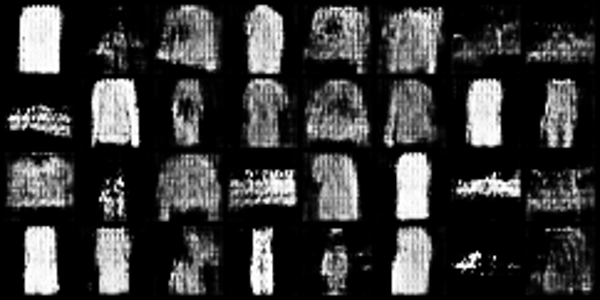

In [7]:
print('output after 10 epcohs:')
image_path = '/scratch/ne2213/projects/DL/HW3-final-batch32/generated_images_epoch_10.png'
img = Image.open(image_path)

# Define the desired size
desired_size = (600, 300)
resized_img = img.resize(desired_size)
resized_img.show()

output after 30 epcohs:


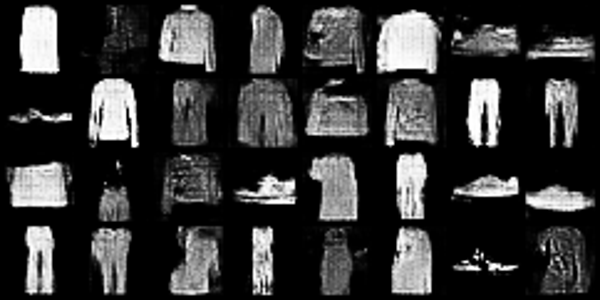

In [8]:
print('output after 30 epcohs:')
image_path = '/scratch/ne2213/projects/DL/HW3-final-batch32/generated_images_epoch_30.png'
img = Image.open(image_path)

# Define the desired size
desired_size = (600, 300)
resized_img = img.resize(desired_size)
resized_img.show()

output after 50 epcohs:


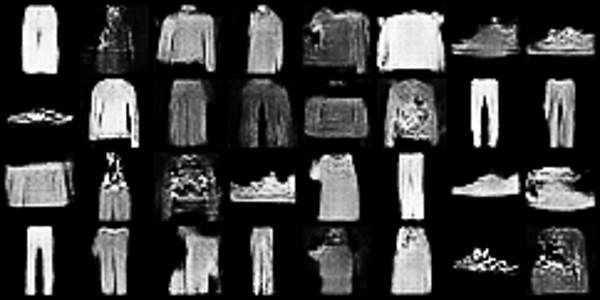

In [9]:
print('output after 50 epcohs:')
image_path = '/scratch/ne2213/projects/DL/HW3-final-batch32/generated_images_epoch_50.png'
img = Image.open(image_path)

# Define the desired size
desired_size = (600, 300)
resized_img = img.resize(desired_size)
resized_img.show()

***As it can be seen from the above examples, the generated results have improved during training***